# MLP 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

df = pd.concat([df1, df2], ignore_index=True)

In [3]:
dfTraining = pd.concat(
    [
        np.array_split(df[df.ae_cl == 0], 3)[0],
        np.array_split(df[df.ae_cl == 0], 3)[1],
        np.array_split(df[df.ae_cl == 1], 3)[0],
        np.array_split(df[df.ae_cl == 1], 3)[1],        
        np.array_split(df[df.ae_cl == 2], 3)[0],
        np.array_split(df[df.ae_cl == 2], 3)[1]
    ],
    ignore_index=True
)


dfTest = pd.concat(
    [
        np.array_split(df[df.ae_cl == 0], 3)[2],
        np.array_split(df[df.ae_cl == 1], 3)[2],
        np.array_split(df[df.ae_cl == 2], 3)[2]
    ],
    ignore_index=True
)

In [2]:
dfTraining = pd.read_csv('postgres_new_data.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


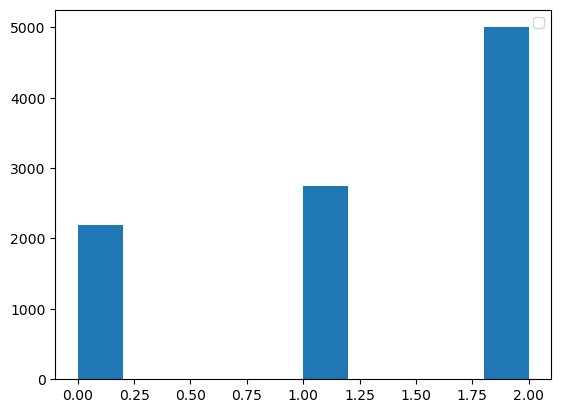

In [4]:
plt.hist([df['ae_cl']])
plt.legend()
plt.show()

In [5]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTraining['mn'] = dfTraining.select_dtypes(include='number').mean(axis=1)
dfTraining['ds'] = dfTraining.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)

In [6]:
X = dfTraining.loc[:, 'rv1':'ds'].astype(float).values
y = dfTraining['ae_cl']

In [7]:
# Preprocessing steps
# Impute missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [8]:
# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
#mlp = MLPRegressor()

In [10]:
# Define the parameter grid to search
'''param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 300]
}'''


"param_grid = {\n    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],\n    'activation': ['relu', 'tanh'],\n    'alpha': [0.0001, 0.001, 0.01],\n    'learning_rate': ['constant', 'invscaling', 'adaptive'],\n    'max_iter': [100, 200, 300]\n}"

In [11]:
# Use GridSearchCV to find the best combination of hyperparameters
'''grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)'''

"grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)\ngrid_search.fit(X_train, y_train)"

In [12]:
# Get the best parameters
#best_params = grid_search.best_params_

In [9]:
#result of gridSearch
params = {'activation': 'tanh',
 'alpha': 0.01,
 'hidden_layer_sizes': (100, 50, 25),
 'learning_rate': 'invscaling',
 'max_iter': 100}

In [10]:
# Train the model with the best parameters
best_model = MLPRegressor(**params)
best_model.fit(X_train, y_train)

MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 50, 25),
             learning_rate='invscaling', max_iter=100)

In [11]:
# Make predictions on the test set
predictions = best_model.predict(X_test)

In [12]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

#print(f"Best parameters: {best_params}")
print(f"Root Mean Squared Error on the test set: {rmse}")
print(f"R-squared on the test set: {r2}")

Root Mean Squared Error on the test set: 0.0430612064669181
R-squared on the test set: 0.9971784196022732


In [13]:
predictionsRound = np.around(predictions, decimals=0)

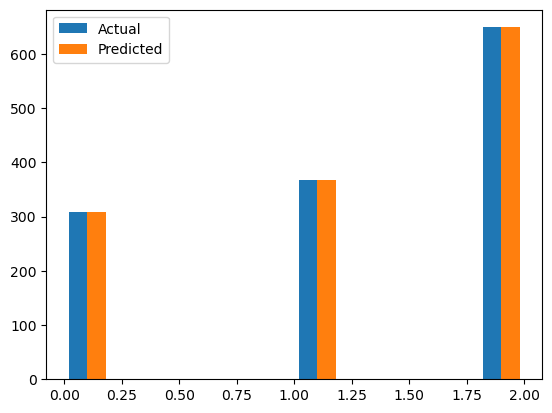

In [14]:
plt.hist([y_test, predictionsRound], label=['Actual', 'Predicted'])
plt.legend()
plt.show()

In [22]:
dfTest = pd.read_csv('postgres_validation_data.csv')

In [23]:
#------------------------ Load and preprocess the data ------------------------

# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTest['mn'] = dfTest.select_dtypes(include='number').mean(axis=1)
dfTest['ds'] = dfTest.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)

dfTest.head()

,tm,knt,ae,ae_cl,rv1,rv2,rv3,rv4,rv5,rv6,...,rv1493,rv1494,rv1495,rv1496,rv1497,rv1498,rv1499,rv1500,mn,ds
0,2024-01-24 01:32:11.3875,1500,0.181943,0,2.0002,1.0001,2.0002,2.0002,2.0002,2.0002,...,1.0001,2.0002,1.0001,2.0002,2.0002,2.0002,2.0002,2.0002,500.060648,707.063901
1,2024-01-24 08:51:04.308806,1500,0.433016,1,20.7519,20.7519,20.7519,20.7519,20.7519,20.7519,...,20.7519,20.7519,21.9726,20.7519,21.9726,20.7519,20.7519,20.7519,500.477672,706.769054
2,2024-01-24 06:37:46.622796,1500,0.532427,1,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,...,1.0001,2.0002,1.0001,2.0002,2.0002,1.0001,2.0002,2.0002,500.510809,706.745610
3,2024-01-24 03:50:26.77633,1500,0.535184,1,2.4414,2.4414,2.4414,2.4414,2.4414,2.4414,...,2.4414,2.4414,2.4414,2.4414,2.4414,1.2207,2.4414,2.4414,500.511728,706.744960
4,2024-01-23 23:25:37.865158,1500,0.460215,1,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,...,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,500.486738,706.762640


In [24]:
new_data = dfTest.loc[:, 'rv1':'ds'].astype(float).values
target_new_data = dfTest['ae_cl']

In [25]:
# Apply the same preprocessing steps to the new data
new_data_imputed = imputer.transform(new_data)
new_data_scaled = scaler.transform(new_data_imputed)

In [26]:
# Use the trained model to make predictions on the new data
new_data_predictions = best_model.predict(new_data_scaled)

In [27]:
newPredictionsRound = np.around(new_data_predictions, decimals=0)

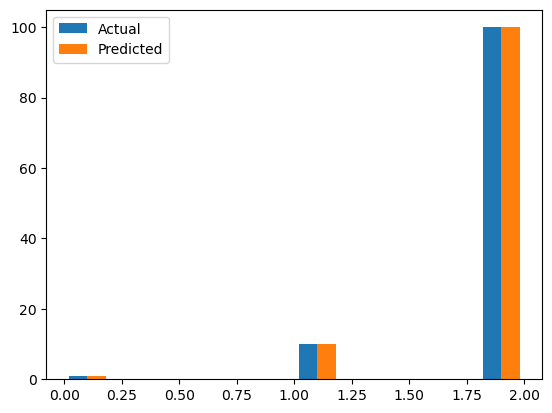

In [28]:
plt.hist([target_new_data, newPredictionsRound], label=['Actual', 'Predicted'])
plt.legend()
plt.show()

# MLP 2

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from sklearn.impute import SimpleImputer
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

df = pd.concat([df1, df2], ignore_index=True)

In [3]:
dfTraining = pd.concat(
    [
        np.array_split(df[df.ae_cl == 0], 3)[0],
        np.array_split(df[df.ae_cl == 0], 3)[1],
        np.array_split(df[df.ae_cl == 1], 3)[0],
        np.array_split(df[df.ae_cl == 1], 3)[1],        
        np.array_split(df[df.ae_cl == 2], 3)[0],
        np.array_split(df[df.ae_cl == 2], 3)[1]
    ],
    ignore_index=True
)


dfTest = pd.concat(
    [
        np.array_split(df[df.ae_cl == 0], 3)[2],
        np.array_split(df[df.ae_cl == 1], 3)[2],
        np.array_split(df[df.ae_cl == 2], 3)[2]
    ],
    ignore_index=True
)

In [4]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTraining['mn'] = dfTraining.select_dtypes(include='number').mean(axis=1)
dfTraining['ds'] = dfTraining.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)

In [5]:
X = dfTraining.loc[:, 'rv1':'ds'].astype(float).values
y = dfTraining['ae_cl']

In [6]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Define the MLP model
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(1502,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [9]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/100


133/133 - 1s - loss: 2.1247 - accuracy: 0.5722 - val_loss: 0.6663 - val_accuracy: 0.6717 - 1s/epoch - 11ms/step
Epoch 2/100
133/133 - 1s - loss: 0.8479 - accuracy: 0.7001 - val_loss: 0.2744 - val_accuracy: 0.9415 - 703ms/epoch - 5ms/step
Epoch 3/100
133/133 - 1s - loss: 0.4134 - accuracy: 0.8157 - val_loss: 0.2091 - val_accuracy: 0.9415 - 798ms/epoch - 6ms/step
Epoch 4/100
133/133 - 1s - loss: 0.2587 - accuracy: 0.8801 - val_loss: 0.1399 - val_accuracy: 0.9443 - 785ms/epoch - 6ms/step
Epoch 5/100
133/133 - 1s - loss: 0.2393 - accuracy: 0.8858 - val_loss: 0.1349 - val_accuracy: 0.9443 - 598ms/epoch - 4ms/step
Epoch 6/100
133/133 - 1s - loss: 0.2030 - accuracy: 0.9028 - val_loss: 0.1244 - val_accuracy: 0.9443 - 585ms/epoch - 4ms/step
Epoch 7/100
133/133 - 1s - loss: 0.2378 - accuracy: 0.8867 - val_loss: 0.1273 - val_accuracy: 0.9443 - 547ms/epoch - 4ms/step
Epoch 8/100
133/133 - 1s - loss: 0.2100 - accuracy: 0.8988 - val_loss: 0.1233 - val_accuracy: 0.9443 - 892ms/epoch - 7

In [10]:

# Predict probabilities for each class
y_pred_probabilities = model.predict(X_test)

# Get the class with the highest probability for each sample
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Calculate and print various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

42/42 [==============================] - 0s 1ms/step
Accuracy: 91.62%
Precision: 0.93
Recall: 0.92
F1 Score: 0.91


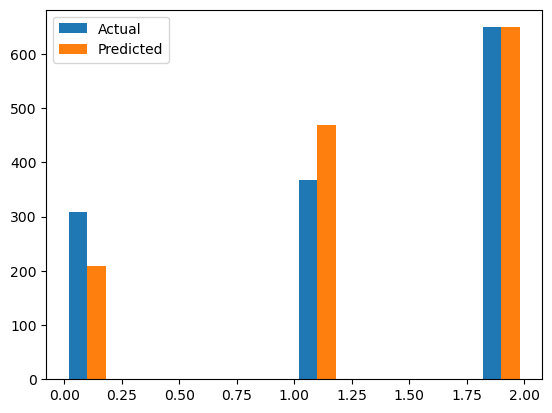

In [11]:
plt.hist([y_test, y_pred], label=['Actual', 'Predicted'])
plt.legend()
plt.show()

In [12]:
#------------------------ Load and preprocess the data ------------------------

# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTest['mn'] = dfTest.select_dtypes(include='number').mean(axis=1)
dfTest['ds'] = dfTest.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)

dfTest.head()

,tm,knt,ae,ae_cl,rv1,rv2,rv3,rv4,rv5,rv6,...,rv1493,rv1494,rv1495,rv1496,rv1497,rv1498,rv1499,rv1500,mn,ds
0,2023-11-27 18:19:18.865912,1500,0.314221,0,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,...,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,500.104740,707.032730
1,2023-11-27 18:20:15.4063,1500,0.215168,0,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,...,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,500.071723,707.056071
2,2023-11-27 18:22:22.580123,1500,0.146769,0,1594.1594,1594.1594,1594.1594,1594.1594,1594.1594,1594.1594,...,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,500.048923,707.072190
3,2023-11-27 18:23:20.619932,1500,0.372232,0,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,...,1592.1592,1592.1592,1592.1592,1592.1592,1591.1591,1592.1592,1591.1591,1592.1592,500.124077,707.019062
4,2023-11-27 18:25:27.777907,1500,0.326013,0,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,1593.1593,...,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,1592.1592,500.108671,707.029952


In [17]:
new_data = dfTest.loc[:, 'rv1':'ds'].astype(float).values
target_new_data = dfTest['ae_cl']

In [18]:
# Standardize the input features
new_data_scaled = scaler.fit_transform(new_data)

In [19]:
# Predict probabilities for each class
new_data_pred_probabilities = model.predict(new_data_scaled)

# Get the class with the highest probability for each sample
new_data_pred = np.argmax(new_data_pred_probabilities, axis=1)

104/104 [==============================] - 0s 1ms/step


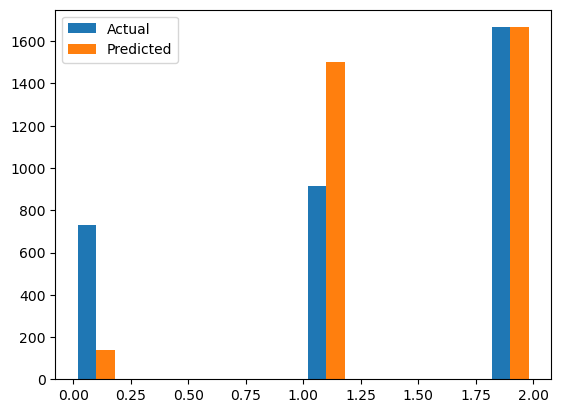

In [20]:
plt.hist([target_new_data, new_data_pred], label=['Actual', 'Predicted'])
plt.legend()
plt.show()

# MLP Logistic Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

In [3]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

dfTraining = pd.concat([df1, df2], ignore_index=True)
dfTraining.head()

,tm,knt,ae,ae_cl,rv
0,2023-05-08 16:09:16.771572,1500,0.326013,0,"3.6620999999999997, 3.6620999999999997, 3.6620..."
1,2023-12-07 05:17:16.98583,1500,0.317388,0,"9.7656, 9.7656, 9.7656, 9.7656, 9.7656, 9.7656..."
2,2023-12-07 12:29:06.618496,1500,0.249031,0,"13.427699999999998, 14.648399999999999, 13.427..."
3,2023-12-08 01:46:33.934387,1500,0.339904,0,"4.0004, 4.0004, 4.0004, 4.0004, 4.0004, 4.0004..."
4,2023-12-08 01:46:35.315528,1500,0.264804,0,"4.0004, 4.0004, 4.0004, 4.0004, 4.0004, 4.0004..."


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


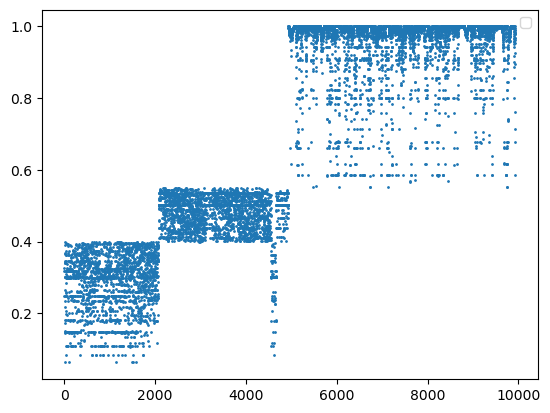

In [5]:
plt.scatter(dfTraining.index,dfTraining['ae'],s = 1)
plt.legend()
plt.show()

In [6]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTraining['mn'] = dfTraining.select_dtypes(include='number').mean(axis=1)
dfTraining['ds'] = dfTraining.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)

In [7]:
X = dfTraining.loc[:, 'rv1':'ds'].astype(float).values
y = dfTraining['ae']

In [8]:
# Preprocessing steps
# Impute missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [9]:
# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
#result of gridSearch
params = {'activation': 'logistic',      
 'alpha': 0.01,
 'hidden_layer_sizes': (200, 100, 50),
 'learning_rate': 'invscaling',
 'max_iter': 200}

In [11]:
# Train the model with the best parameters
best_model = MLPRegressor(**params)
best_model.fit(X_train, y_train)

MLPRegressor(activation='logistic', alpha=0.01,
             hidden_layer_sizes=(200, 100, 50), learning_rate='invscaling')

In [12]:
# Make predictions on the test set
predictions = best_model.predict(X_test)

In [13]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

#print(f"Best parameters: {best_params}")
print(f"Root Mean Squared Error on the test set: {rmse}")
print(f"R-squared on the test set: {r2}")

Root Mean Squared Error on the test set: 0.0563952900189096
R-squared on the test set: 0.9638340275252323


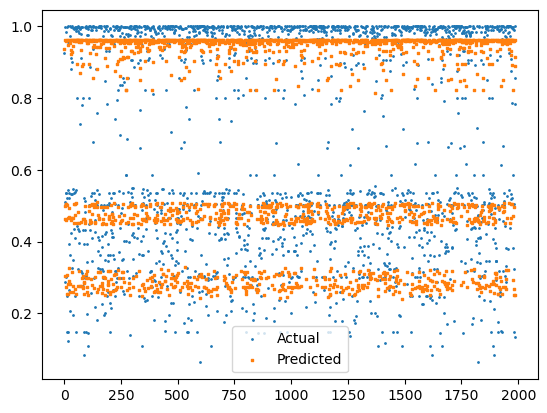

In [14]:
plt.scatter( [n + 1 for n in range(len(y_test))], y_test,s = 1, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(predictions))],predictions,s = 1, marker = 's', label = 'Predicted')
plt.legend()
plt.show()

In [15]:
dfTest = pd.read_csv('postgres_validation_data.csv')

In [16]:
dfTest = pd.read_csv('postgres_validation_data.csv')
#------------------------ Load and preprocess the data ------------------------

# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTest['mn'] = dfTest.select_dtypes(include='number').mean(axis=1)
dfTest['ds'] = dfTest.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)

dfTest.head()

,tm,knt,ae,ae_cl,rv1,rv2,rv3,rv4,rv5,rv6,...,rv1493,rv1494,rv1495,rv1496,rv1497,rv1498,rv1499,rv1500,mn,ds
0,2024-01-24 01:32:11.3875,1500,0.181943,0,2.0002,1.0001,2.0002,2.0002,2.0002,2.0002,...,1.0001,2.0002,1.0001,2.0002,2.0002,2.0002,2.0002,2.0002,500.060648,707.063901
1,2024-01-24 08:51:04.308806,1500,0.433016,1,20.7519,20.7519,20.7519,20.7519,20.7519,20.7519,...,20.7519,20.7519,21.9726,20.7519,21.9726,20.7519,20.7519,20.7519,500.477672,706.769054
2,2024-01-24 06:37:46.622796,1500,0.532427,1,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,...,1.0001,2.0002,1.0001,2.0002,2.0002,1.0001,2.0002,2.0002,500.510809,706.745610
3,2024-01-24 03:50:26.77633,1500,0.535184,1,2.4414,2.4414,2.4414,2.4414,2.4414,2.4414,...,2.4414,2.4414,2.4414,2.4414,2.4414,1.2207,2.4414,2.4414,500.511728,706.744960
4,2024-01-23 23:25:37.865158,1500,0.460215,1,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,...,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,2.0002,500.486738,706.762640


In [17]:
new_data = dfTest.loc[:, 'rv1':'ds'].astype(float).values
target_new_data = dfTest['ae']

In [18]:
# Apply the same preprocessing steps to the new data
new_data_imputed = imputer.transform(new_data)
new_data_scaled = scaler.transform(new_data_imputed)

In [19]:
# Use the trained model to make predictions on the new data
new_data_predictions = best_model.predict(new_data_scaled)

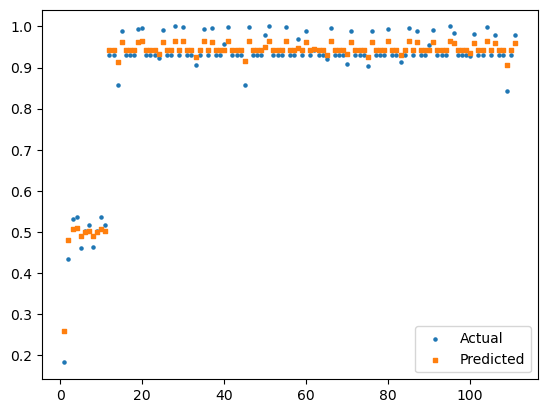

In [20]:
plt.scatter( [n + 1 for n in range(len(target_new_data))], target_new_data,s = 5, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(new_data_predictions))],new_data_predictions,s = 5, marker = 's', label = 'Predicted')
plt.legend()
plt.show()

# MLP Logistic Regression (TensorFlow)

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

In [2]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

dfTraining = pd.concat([df1, df2], ignore_index=True)
dfTraining.head()

,tm,knt,ae,ae_cl,rv
0,2023-05-08 16:09:16.771572,1500,0.326013,0,"3.6620999999999997, 3.6620999999999997, 3.6620..."
1,2023-12-07 05:17:16.98583,1500,0.317388,0,"9.7656, 9.7656, 9.7656, 9.7656, 9.7656, 9.7656..."
2,2023-12-07 12:29:06.618496,1500,0.249031,0,"13.427699999999998, 14.648399999999999, 13.427..."
3,2023-12-08 01:46:33.934387,1500,0.339904,0,"4.0004, 4.0004, 4.0004, 4.0004, 4.0004, 4.0004..."
4,2023-12-08 01:46:35.315528,1500,0.264804,0,"4.0004, 4.0004, 4.0004, 4.0004, 4.0004, 4.0004..."


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


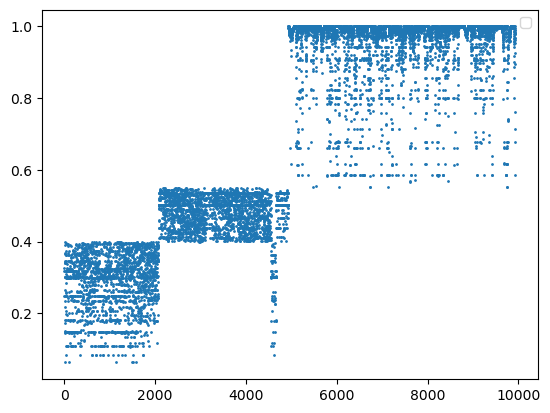

In [3]:
plt.scatter(dfTraining.index,dfTraining['ae'],s = 1)
plt.legend()
plt.show()

In [4]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTraining['mn'] = dfTraining.select_dtypes(include='number').mean(axis=1)
dfTraining['ds'] = dfTraining.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)

In [5]:
X = dfTraining.loc[:, 'rv1':'ds'].astype(float).values
y = dfTraining['ae']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
# Define the model
model = Sequential()
model.add(Dense(1502, input_dim=1502, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [7]:
# Compile the model with mean squared error as the loss
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
249/249 [==============================] - 2s 3ms/step - loss: 0.0085 - mae: 0.0589
Epoch 2/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0029 - mae: 0.0355
Epoch 3/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0023 - mae: 0.0311
Epoch 4/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0028 - mae: 0.0327
Epoch 5/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0026 - mae: 0.0316
Epoch 6/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0017 - mae: 0.0267
Epoch 7/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0014 - mae: 0.0248
Epoch 8/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0014 - mae: 0.0236
Epoch 9/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0015 - mae: 0.0241
Epoch 10/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0013 - mae: 0.0230
Epoch 11/50
249/249 [============================

In [9]:
predictions = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [11]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

#print(f"Best parameters: {best_params}")
print(f"Root Mean Squared Error on the test set: {rmse}")
print(f"R-squared on the test set: {r2}")

Root Mean Squared Error on the test set: 0.019764972318011085
R-squared on the test set: 0.9955577100729005


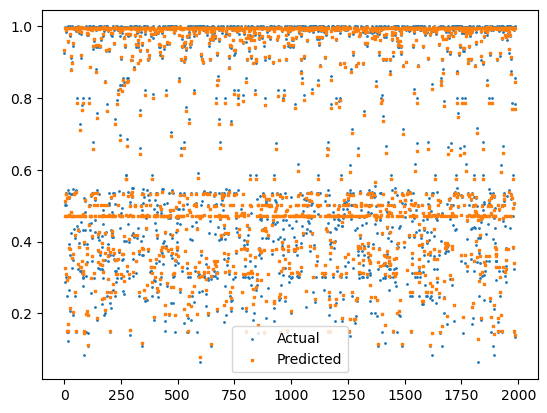

In [12]:
plt.scatter( [n + 1 for n in range(len(y_test))], y_test,s = 1, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(predictions))],predictions,s = 1, marker = 's', label = 'Predicted')
plt.legend()
plt.show()

In [13]:
dfTest = pd.read_csv('postgres_validation_data.csv')
#------------------------ Load and preprocess the data ------------------------

# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

dfTest['mn'] = dfTest.select_dtypes(include='number').mean(axis=1)
dfTest['ds'] = dfTest.select_dtypes(include='number').std(axis=1)

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)

new_data = dfTest.loc[:, 'rv1':'ds'].astype(float).values
target_new_data = dfTest['ae']

In [14]:
new_data = scaler.fit_transform(new_data)

In [15]:
new_data_predictions = model.predict(new_data)

4/4 [==============================] - 0s 4ms/step


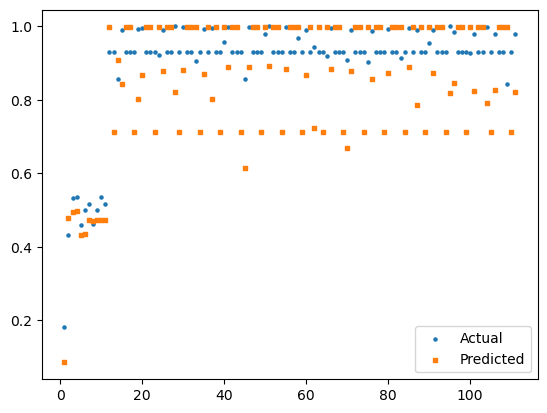

In [16]:
plt.scatter( [n + 1 for n in range(len(target_new_data))], target_new_data,s = 5, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(new_data_predictions))],new_data_predictions,s = 5, marker = 's', label = 'Predicted')
plt.legend()
plt.show()